# Part 2 - Advanced text classifiers

As seen in the past, we can create models that take advantage of counts of words and tf-idf scores and that yield some pretty accurate predictions. But it is possible to make use of several additional features to improve our classifier. In this learning unit we are going to check how we could use other data extracted from our text data to determine if an e-mail is 'spam' or 'not spam' (also known as ham). We are going to use a very well known Kaggle dataset for spam detection - [Kaggle Spam Collection](https://www.kaggle.com/uciml/sms-spam-collection-dataset). 

![ham_or_spam](../media/ham_spam.jpg)

This part will also introduce you to feature unions, a very useful way of combining different feature sets into your models. This scikit-learn class comes hand-in-hand with pipelines. Both allow you to delegate the work of combining and piping your transformer's outputs - your features - allowing you to create workflows in a very simple way.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import FeatureUnion

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler

from nltk.corpus import stopwords

## 1 - Spam and Ham

As we mentioned before, we are going to try and come up with ways of detecting spam in the Kaggle Spam dataset. Let's load it and look into the data.

In [2]:
df = pd.read_csv('../datasets/spam.csv', encoding='latin1')
df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1,inplace=True)
df.rename(columns={"v1":"label", "v2":"message"},inplace=True)
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


You could think it should be quite easy to detect the spam text, since it is clearer to the human eye. I don't know about you, but I'm always suspicious of free stuff. There ain't no such thing as a free lunch (except for the ones in our hackathons).

But by now you should also know that what seems obvious in text to us is sometimes not as easy to detect by a model. So, what kind of features could you use for this? The most obvious one is the words themselves, which you already know how to use with your bag-of-words approach - using CountVectorizer or TfIdfVectorizer.


## 1.1 - Baseline

Let's get our baseline with the Bag-of-words approach. Here we are going to use a RandomForestClassifier, a powerful machine learning classifier that fits very well in this problem. The usage of RandomForestClassifier in sckit-learn is similar to the other classifiers we already used.


In [3]:
# Split in train and validation
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# Build the pipeline
text_clf = Pipeline([('tfidf', TfidfVectorizer()),
                   ('classifier', RandomForestClassifier(random_state = 42))])

# Train the classifier
text_clf.fit(map(str, train_data['message'].values), train_data['label'].values)

predicted = text_clf.predict(map(str, test_data['message'].values))
np.mean(predicted == test_data['label'])

0.9659192825112107

Powerful words, no?

Our next step is to include other features. 

## 1.2 - Adding extra features

But, beside this vectorization as a bag-of-words, let's understand if our classifier could feed in other statistical data we could retrieve from the text. Let's check for example the **length of the message**. We'll first compute it and add it as a feature in our dataframe.

In [4]:
df['length'] = df['message'].apply(lambda x: len(x))
df.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


**Is this feature useful?** 

Since this is only one numerical feature, we can just simply plot its distribution in our data. Let's evaluate the length distribution for "Spam" and "Ham"

(0, 300)

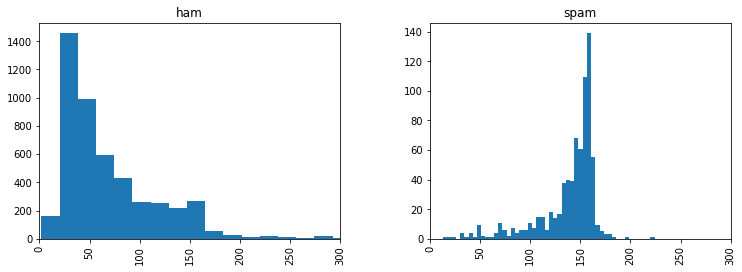

In [5]:
ax_list = df.hist(column='length', by='label', bins=50,figsize=(12,4))
ax_list[0].set_xlim((0,300))
ax_list[1].set_xlim((0,300))

Seems quite different, right? So you would guess this feature should be helpful in your classifier.

But let's actually check this feature through the use of a text classifier. Now for the tricky parts.

### Preprocessing 

If BLU7 is still fresh on you, you remember that when using pipelines we just fed it with the text column. In fact, we could feed it more than one column, but the standard preprocessing applies the same preprocessing to the whole dataset, and for our heterogeneous data, this doesn't quite work. 

So what can we do if we want to have a pipeline using several different features from several different columns? We can't apply the same methods to everything right? So first thing we can do is to create a selector transformer that simply returns the right column in the dataset by the key value you pass.

We start then by defining these selectors, in our case, we have two different selectors, one for text, other for numeric columns. The return type is different, but other than that they work the same.

In [6]:
class TextSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

And then we define pipelines tailored for each of our cases.

See how the length is defined by the usage of NumberSelector. Notice that we used the **StandardScaler**. The use of this scaler (scales the feature to zero mean and to one in variance) is because we don't want to have different feature dimensions in our classifier. Most of classification algorithms expect the **features to be in the same scale**!  

In [7]:
text = Pipeline([
                ('selector', TextSelector(key='message')),
                ('tfidf', TfidfVectorizer())
            ])

length =  Pipeline([
                ('selector', NumberSelector(key='length')),
                ('standard', StandardScaler())
            ])

You might be wondering now:

> *How does this solve my problem... now I have two pipelines and although I can feed my whole dataset they are separate pipelines... does this help at all?*

In fact, if you were to run them separately this would not be that helpful, since you would have to add the classifier at the end of each. It seems like we are missing only one piece, a way to combine steps in parallel and not in sequence. This is where feature unions come in!


## 1.3 - Feature Unions

While pipelines define a cascaded workflow, feature unions allow you to parallelize your workflows and have several transformations applied in parallel to your pipeline. The image below presents a simple pipeline, in sequence:

<img src="../media/pipeline.png" width="40%">

While the following one presents what it is called a feature union:

<img src="../media/unions.png" width="70%">

The latter is quite simple to define in scikit-learn, as follows:

In [8]:
# Feature Union allow use to use multiple distinct features in our classifier
feats = FeatureUnion([('text', text), 
                      ('length', length)])

Now you can use this combination of pipelines and feature unions inside a new pipeline! 

<img src="../media/pipelines_dawg.png" width="45%">

We then get our final flow, from where we can extract the classification score.

In [9]:
# Split in train and validation
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])

pipeline.fit(train_data, train_data.label)

preds = pipeline.predict(test_data)
np.mean(preds == test_data.label)

0.9713004484304932

Our new feature does help! We got a slightly improvement from a baseline that was already quite high. Nicely done. Let's now play with other more complex text features and see if we can maximize our classification score even more. 

## 1.4 - Advanced features

What kind of features can you think of? 

You could start by just having the number of words, in the same way that we had the character length of the sentence:

In [10]:
df['words'] = df['message'].str.split(' ').map(len)

Remember BLU7? Remember stopwords?  

<img src="../media/stopwords.png" width="40%">

Let's count only words that are not stopwords, since these are normally less relevant.

In [11]:
stop_words = set(stopwords.words('english'))
df['words_not_stopword'] = df['message'].apply(lambda x: len([t for t in x.split(' ') if t not in stop_words]))

In the same way, we can apply counts conditioned on other different characteristics, like counting the number of commas in the sentence or the number of words that are uppercased or capitalized:

In [12]:
df['commas'] = df['message'].str.count(',')
df['upper'] = df['message'].map(lambda x: map(str.isupper, x)).map(sum)
df['capitalized'] = df['message'].map(lambda x: map(str.istitle, x)).map(sum)

We can also model the type of words by their length, for example:

In [13]:
#get the average word length
df['avg_word_length'] = df['message'].apply(lambda x: np.mean([len(t) for t in x.split(' ') if t not in stop_words]) if len([len(t) for t in x.split(' ') if t not in stop_words]) > 0 else 0)

Let's take a look then at our output data frame, and all the features we added:

In [14]:
df.head()

,label,message,length,words,words_not_stopword,commas,upper,capitalized,avg_word_length
0,ham,"Go until jurong point, crazy.. Available only ...",111,20,16,1,3,3,4.750000
1,ham,Ok lar... Joking wif u oni...,29,6,6,0,2,2,4.000000
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28,23,0,10,10,5.173913
3,ham,U dun say so early hor... U c already then say...,49,11,9,0,2,2,3.666667
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,13,8,1,2,2,4.250000


And now we can use the Feature Unions that we learned about to merge all these together. We'll split the data, create pipelines for all our new features and get their unions. Easy, right? 

In [15]:
words =  Pipeline([
                ('selector', NumberSelector(key='words')),
                ('standard', StandardScaler())
            ])
words_not_stopword =  Pipeline([
                ('selector', NumberSelector(key='words_not_stopword')),
                ('standard', StandardScaler())
            ])
avg_word_length =  Pipeline([
                ('selector', NumberSelector(key='avg_word_length')),
                ('standard', StandardScaler())
            ])
commas =  Pipeline([
                ('selector', NumberSelector(key='commas')),
                ('standard', StandardScaler()),
            ])
upper =  Pipeline([
                ('selector', NumberSelector(key='upper')),
                ('standard', StandardScaler()),
            ])
capitalized =  Pipeline([
                ('selector', NumberSelector(key='capitalized')),
                ('standard', StandardScaler()),
            ])

feats = FeatureUnion([('text', text), 
                      ('length', length),
                      ('words', words),
                      ('words_not_stopword', words_not_stopword),
                      ('avg_word_length', avg_word_length),
                      ('commas', commas),
                     ('upper', upper),
                     ('capitalized', capitalized)])

feature_processing = Pipeline([('feats', feats)])

We ended with our classifier so let's run it and get our classification score. 

*Drumroll, please.*

In [16]:
# Split in train and validation
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])

pipeline.fit(train_data, train_data.label)

preds = pipeline.predict(test_data)
np.mean(preds == test_data.label)

0.9721973094170404

<img src="../media/sad.png" width="40%">

Although we are still above the baseline, we didn't surpass by much the score of using just the text and its length. But don't despair, with all the tools from BLU7, BLU8 and the first part of this BLU you are already perfectly equipped to find yet new features and to analyze if they are good or not. Even to integrate your pipelines with dimensionality reduction techniques that might find your meaningful features among all these.

## 2 - Other classifiers

New approaches in text processing have arised with new machine learning methods known as deep learning. The usage of deep learning methods is out of the scope for this BLU, but it is important that the reader is aware of the potential of such methods to improve over traditional machine learning algorithms. In particular, we suggest the knowledge about two different classifiers besides sklearn.

* [StarSpace](https://github.com/facebookresearch/StarSpace)
* [Vowpal Wabbit classifier](https://github.com/JohnLangford/vowpal_wabbit/wiki)

### Additional Pointers

* https://www.kaggle.com/baghern/a-deep-dive-into-sklearn-pipelines
* http://zacstewart.com/2014/08/05/pipelines-of-featureunions-of-pipelines.html
* http://michelleful.github.io/code-blog/2015/06/20/pipelines/
* http://scikit-learn.org/stable/auto_examples/hetero_feature_union.html#sphx-glr-auto-examples-hetero-feature-union-py



## 3 - Final remarks

And we are at the end of our NLP specialization. It saddens me, but it is time to say goodbye. 

Throughout these BLUs you learned:

* How to process text 
* Typicall text features used in classification tasks
* State of the art techniques to encode text
* Methods to analyze feature importance
* Methods to perform feature reduction
* How to design pipelines and combine different features inside them

You are now armed with several tools to perform text classification and much more in NLP. Don't forget to review all of this for the NLP hackathon, and to do your best in the Exercises.

<img src="../media/so_long.jpg" width="40%">